# Extension of LCCDE
by Kyle Berryman, Carson Rivera, Olivia Martinez, Philip Ervin and Samuel Manzanares


Original Paper:  
L. Yang, A. Shami, G. Stevens, and S. DeRusett, “LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles," in 2022 IEEE Global Communications Conference (GLOBECOM), 2022, pp. 1-6.

In [1]:
# dependencies

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

## Pre-Processing

In [2]:
#Read dataset

df = pd.read_csv('./data/CICIDS2017_sample.csv') 

In [3]:
# Same Pre-processing / Normalization that Authors implemented

# Z-score normalization
import sklearn.preprocessing
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# Fill empty values by 0
df = df.fillna(0)
labelencoder = sklearn.preprocessing.LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

# Variables for k means sampling
A = X
b = y
df_minor_km = df_minor
df_major_km = df_major

### Data Sampling using DBSCAN instead of K Means

In [4]:
# using DBSCAN to cluster sample and select data from each cluster instead of KMeans

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
df_major['dbscan_label'] = dbscan.labels_

In [5]:
# same sampling method originally used by authors

cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'dbscan_label', group_keys=False
).apply(typicalSampling)

result = result.drop(['dbscan_label'],axis=1)
result = pd.concat([result, df_minor], ignore_index=True)

In [6]:
# output to csv

result.to_csv('./data/CICIDS2017_sample_db.csv',index=0)

### Replicating Original K Means Sampling w Sample Dataset For Fair Comparison

In [7]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)
klabel=kmeans.labels_
df_major_km['klabel']=klabel

cols = list(df_major_km)
cols.insert(78, cols.pop(cols.index('Label')))
df_major_km = df_major_km.loc[:, cols]

def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result_km = df_major_km.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

result_km = result_km.drop(['klabel'],axis=1)
result_km = pd.concat([result_km, df_minor_km], ignore_index=True)
result_km.to_csv('./data/CICIDS2017_sample_km_2.csv',index=0)

## Modeling

In [8]:
# read csvs sampled using DBSCAN and replicated original for comparison

df = pd.read_csv("./data/CICIDS2017_sample_db.csv")
df_original = pd.read_csv("./data/CICIDS2017_sample_km_2.csv")

In [9]:
# Split into Train/Test sets

# dbscan sample
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0)

# original kmeans sample
A = df_original.drop(['Label'],axis=1)
b = df_original['Label']
A_train, A_test, b_train, b_test = train_test_split(A,b, train_size = 0.8, test_size = 0.2, random_state = 0)

In [10]:
# compare label counts

pd.Series(y_train).value_counts()

Label
6    1750
1    1564
0     143
3      93
5      51
4      27
2      16
Name: count, dtype: int64

In [11]:
pd.Series(b_train).value_counts()

Label
6    1747
1    1570
3      96
0      95
5      53
4      25
2      17
Name: count, dtype: int64

Very similar results from each clustering method.

### Model Training: 3 Models included in original paper & some additions

#### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6765
[LightGBM] [Info] Number of data points in the train set: 3644, number of used features: 62
[LightGBM] [Info] Start training from score -3.237993
[LightGBM] [Info] Start training from score -0.845835
[LightGBM] [Info] Start training from score -5.428249
[LightGBM] [Info] Start training from score -3.668238
[LightGBM] [Info] Start training from score -4.905000
[LightGBM] [Info] Start training from score -4.269012
[LightGBM] [Info] Start training from score -0.733466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

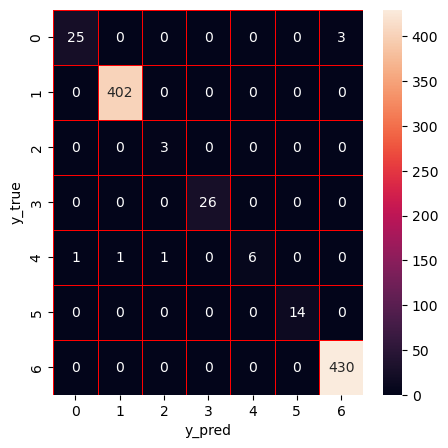

CPU times: user 1.57 s, sys: 1.82 s, total: 3.39 s
Wall time: 1.64 s


In [12]:
%%time
# Train the LightGBM algorithm on DBSCAN data
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6457
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 63
[LightGBM] [Info] Start training from score -3.635645
[LightGBM] [Info] Start training from score -0.830691
[LightGBM] [Info] Start training from score -5.356309
[LightGBM] [Info] Start training from score -3.625174
[LightGBM] [Info] Start training from score -4.970646
[LightGBM] [Info] Start training from score -4.219230
[LightGBM] [Info] Start training from score -0.723867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

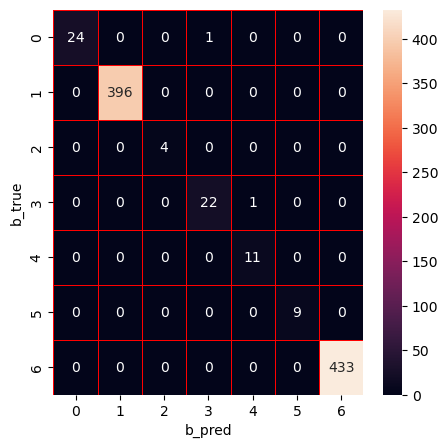

CPU times: user 1.51 s, sys: 1.7 s, total: 3.21 s
Wall time: 1.49 s


In [13]:
%%time
# Train the LightGBM algorithm on k means data
import lightgbm as lgb
lg_km = lgb.LGBMClassifier()
lg_km.fit(A_train, b_train)
b_pred = lg_km.predict(A_test)
print(classification_report(b_test,b_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(b_test, b_pred)))
print("Precision of LightGBM: "+ str(precision_score(b_test, b_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(b_test, b_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(b_test, b_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(b_test, b_pred, average=None)))
lg_f1_km=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(b_test, b_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("b_pred")
plt.ylabel("b_true")
plt.show()

DBSCAN data performs better for 3 of the 7 classifications

#### XG Boost

              precision    recall  f1-score   support

           0       0.96      0.79      0.86        28
           1       0.99      1.00      0.99       402
           2       1.00      1.00      1.00         3
           3       0.93      1.00      0.96        26
           4       1.00      0.56      0.71         9
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00       430

    accuracy                           0.99       912
   macro avg       0.98      0.91      0.93       912
weighted avg       0.99      0.99      0.99       912

Accuracy of XGBoost: 0.9890350877192983
Precision of XGBoost: 0.9890308664026245
Recall of XGBoost: 0.9890350877192983
Average F1 of XGBoost: 0.9880923712397047
F1 of XGBoost for each type of attack: [0.8627451  0.99381953 1.         0.96296296 0.71428571 1.
 0.99767981]


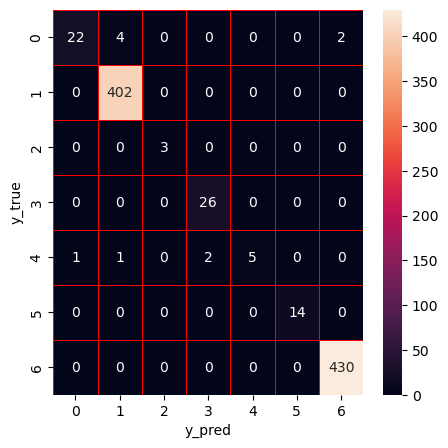

CPU times: user 756 ms, sys: 375 ms, total: 1.13 s
Wall time: 577 ms


In [14]:
%%time
# Train the XGBoost algorithm on DBSCAN data
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       1.00      1.00      1.00       396
           2       0.67      1.00      0.80         4
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00       433

    accuracy                           1.00       901
   macro avg       0.95      0.99      0.97       901
weighted avg       1.00      1.00      1.00       901

Accuracy of XGBoost: 0.9977802441731409
Precision of XGBoost: 0.9985201627820941
Recall of XGBoost: 0.9977802441731409
Average F1 of XGBoost: 0.9979559748427672
F1 of XGBoost for each type of attack: [0.95833333 1.         0.8        1.         1.         1.
 1.        ]


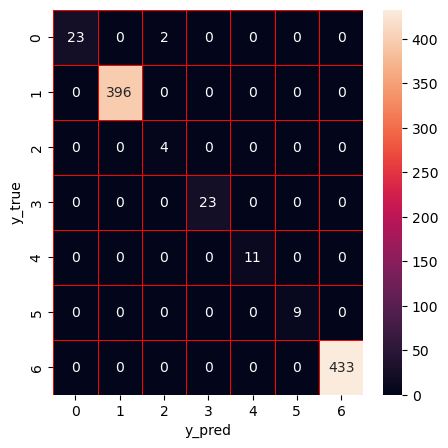

CPU times: user 606 ms, sys: 310 ms, total: 916 ms
Wall time: 520 ms


In [15]:
%%time
# Train the XGBoost algorithm on kmeans data
import xgboost as xgb
xg_km = xgb.XGBClassifier()

A_train_a = A_train.values
A_test_a = A_test.values

xg_km.fit(A_train_a, b_train)

b_pred = xg_km.predict(A_test_a)
print(classification_report(b_test,b_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(b_test,b_pred)))
print("Precision of XGBoost: "+ str(precision_score(b_test,b_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(b_test,b_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(b_test,b_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(b_test,b_pred, average=None)))
xg_f1_km=f1_score(b_test, b_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(b_test,b_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

DBSCAN only performs better in 1 of the 7 classifications

#### Cat Boost

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.99      1.00      1.00       402
           2       1.00      1.00      1.00         3
           3       0.96      1.00      0.98        26
           4       1.00      0.67      0.80         9
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00       430

    accuracy                           0.99       912
   macro avg       0.99      0.94      0.96       912
weighted avg       0.99      0.99      0.99       912

Accuracy of CatBoost: 0.993421052631579
Precision of CatBoost: 0.9934961825860947
Recall of CatBoost: 0.993421052631579
Average F1 of CatBoost: 0.993018009534737
F1 of CatBoost for each type of attack: [0.94339623 0.99628253 1.         0.98113208 0.8        1.
 0.99767981]


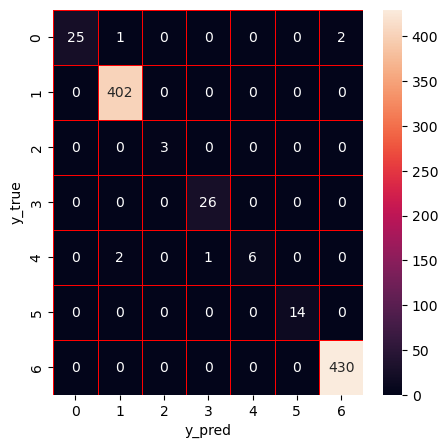

CPU times: user 47.1 s, sys: 1.96 s, total: 49.1 s
Wall time: 8.15 s


In [16]:
%%time
# Train the CatBoost algorithm on DBSCAN
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       1.00      1.00      1.00       396
           2       0.67      1.00      0.80         4
           3       1.00      0.96      0.98        23
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00       433

    accuracy                           1.00       901
   macro avg       0.95      0.98      0.96       901
weighted avg       1.00      1.00      1.00       901

Accuracy of CatBoost: 0.9966703662597114
Precision of CatBoost: 0.9973640399556049
Recall of CatBoost: 0.9966703662597114
Average F1 of CatBoost: 0.9968460340110887
F1 of CatBoost for each type of attack: [0.93877551 1.         0.8        0.97777778 1.         1.
 1.        ]


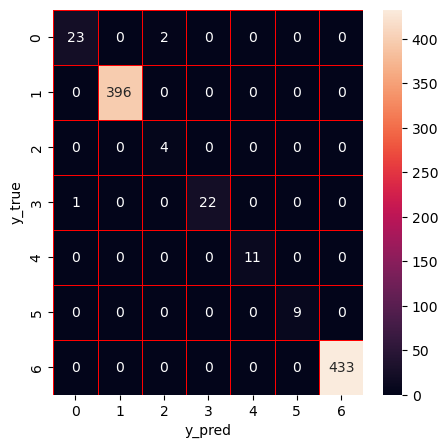

CPU times: user 43.6 s, sys: 1.86 s, total: 45.4 s
Wall time: 7.29 s


In [17]:
%%time
# Train the CatBoost algorithm on k means
import catboost as cbt
cb_km = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb_km.fit(A_train, b_train)
b_pred = cb_km.predict(A_test)
print(classification_report(b_test,b_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(b_test,b_pred)))
print("Precision of CatBoost: "+ str(precision_score(b_test,b_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(b_test,b_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(b_test,b_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(b_test,b_pred, average=None)))
cb_f1_km=f1_score(b_test,b_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(b_test,b_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Data preprocessed w/ DBSCAN does not perform better than the data preprocessed with Kmeans in any case.

#### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       1.00      1.00      1.00       402
           2       0.75      1.00      0.86         3
           3       0.93      1.00      0.96        26
           4       0.75      0.67      0.71         9
           5       1.00      1.00      1.00        14
           6       0.99      1.00      1.00       430

    accuracy                           0.99       912
   macro avg       0.90      0.91      0.90       912
weighted avg       0.99      0.99      0.99       912

Accuracy of Decision Tree Classifier: 0.9879385964912281
Precision of Decision Tree Classifier: 0.9875375756105808
Recall of Decision Tree Classifier: 0.9879385964912281
Average F1 of Decision Tree Classifier: 0.9872485373291616
F1 of Decision Tree Classifier for each type of attack: [0.8        1.         0.85714286 0.96296296 0.70588235 1.
 0.99537037]


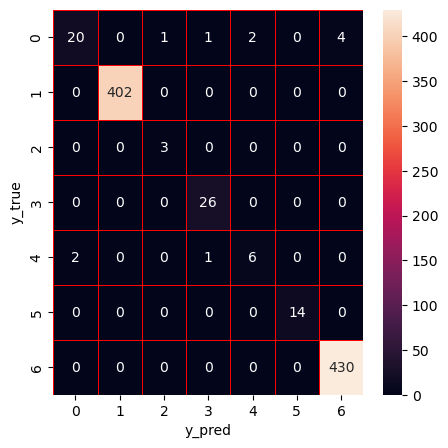

CPU times: user 131 ms, sys: 5.18 ms, total: 136 ms
Wall time: 138 ms


In [18]:
%%time
# Train the decision tree classifier on dbscan
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini', min_weight_fraction_leaf=1e-100000000)

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of Decision Tree Classifier: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of Decision Tree Classifier: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of Decision Tree Classifier: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of Decision Tree Classifier: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Decision Tree Classifier for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
dtc_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.55      0.64      0.59        25
           1       0.93      1.00      0.96       396
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        11
           5       1.00      0.44      0.62         9
           6       0.98      1.00      0.99       433

    accuracy                           0.94       901
   macro avg       0.49      0.44      0.45       901
weighted avg       0.90      0.94      0.92       901

Accuracy of Decision Tree Classifier: 0.9400665926748057
Precision of Decision Tree Classifier: 0.9026956810554313
Recall of Decision Tree Classifier: 0.9400665926748057
Average F1 of Decision Tree Classifier: 0.9195546463689346
F1 of Decision Tree Classifier for each type of attack: [0.59259259 0.96116505 0.         0.         0.         0.61538462
 0.98739977]


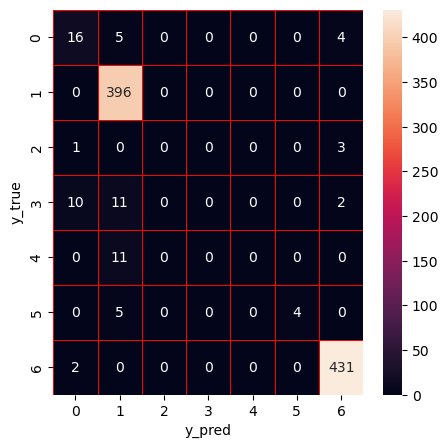

CPU times: user 163 ms, sys: 5.51 ms, total: 169 ms
Wall time: 169 ms


In [19]:
%%time
# Train the decision tree classifier on kmeans
from sklearn.tree import DecisionTreeClassifier
dtc_km = DecisionTreeClassifier(criterion='gini', min_weight_fraction_leaf=1e-100000000)

dtc_km.fit(A_train, b_train)
b_pred = dtc_km.predict(A_test)
print(classification_report(b_test,b_pred))
print("Accuracy of Decision Tree Classifier: "+ str(accuracy_score(b_test,b_pred)))
print("Precision of Decision Tree Classifier: "+ str(precision_score(b_test,b_pred, average='weighted')))
print("Recall of Decision Tree Classifier: "+ str(recall_score(b_test,b_pred, average='weighted')))
print("Average F1 of Decision Tree Classifier: "+ str(f1_score(b_test,b_pred, average='weighted')))
print("F1 of Decision Tree Classifier for each type of attack: "+ str(f1_score(b_test,b_pred, average=None)))
dtc_f1_km=f1_score(b_test,b_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(b_test,b_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

DBSCAN performs better in 4 of the 7 cases.

#### Bagging Classifier

              precision    recall  f1-score   support

           0       0.89      0.61      0.72        28
           1       0.98      1.00      0.99       402
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00        26
           4       1.00      0.67      0.80         9
           5       1.00      1.00      1.00        14
           6       0.99      1.00      1.00       430

    accuracy                           0.98       912
   macro avg       0.95      0.90      0.91       912
weighted avg       0.98      0.98      0.98       912

Accuracy of Bagging Classifier: 0.9846491228070176
Precision of Bagging Classifier: 0.9840784148676783
Recall of Bagging Classifier: 0.9846491228070176
Average F1 of Bagging Classifier: 0.9830826435919318
F1 of Bagging Classifier for each type of attack: [0.72340426 0.99014778 0.85714286 1.         0.8        1.
 0.99652375]


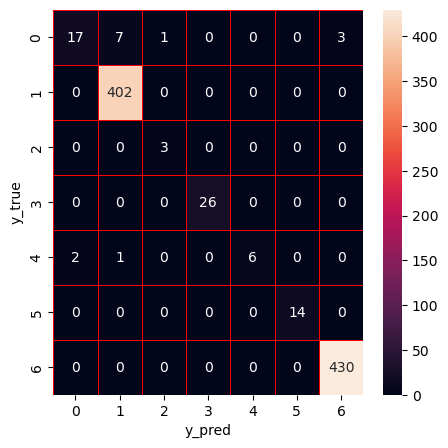

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bc = BaggingClassifier(KNeighborsClassifier(), n_estimators=10, random_state=0)

bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of Bagging Classifier: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of Bagging Classifier: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of Bagging Classifier: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of Bagging Classifier: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Bagging Classifier for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
bc_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.60      0.70        25
           1       0.99      1.00      0.99       396
           2       0.50      0.75      0.60         4
           3       0.95      0.83      0.88        23
           4       1.00      0.82      0.90        11
           5       0.80      0.89      0.84         9
           6       0.99      1.00      1.00       433

    accuracy                           0.98       901
   macro avg       0.87      0.84      0.84       901
weighted avg       0.98      0.98      0.98       901

Accuracy of Bagging Classifier: 0.9800221975582686
Precision of Bagging Classifier: 0.9800025424476086
Recall of Bagging Classifier: 0.9800221975582686
Average F1 of Bagging Classifier: 0.9791024067097543
F1 of Bagging Classifier for each type of attack: [0.69767442 0.99372647 0.6        0.88372093 0.9        0.84210526
 0.9954023 ]


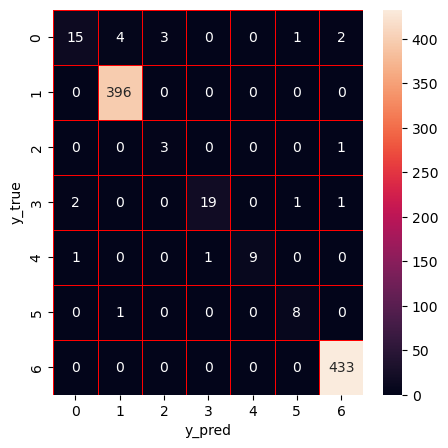

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bc_km = BaggingClassifier(KNeighborsClassifier(), n_estimators=10, random_state=0)

A_train.drop(columns='dbscan_label', inplace=True)
A_test.drop(columns='dbscan_label', inplace=True)
bc_km.fit(A_train, b_train)
b_pred = bc_km.predict(A_test)
print(classification_report(b_test,b_pred))
print("Accuracy of Bagging Classifier: "+ str(accuracy_score(b_test,b_pred)))
print("Precision of Bagging Classifier: "+ str(precision_score(b_test,b_pred, average='weighted')))
print("Recall of Bagging Classifier: "+ str(recall_score(b_test,b_pred, average='weighted')))
print("Average F1 of Bagging Classifier: "+ str(f1_score(b_test,b_pred, average='weighted')))
print("F1 of Bagging Classifier for each type of attack: "+ str(f1_score(b_test,b_pred, average=None)))
bc_f1_km=f1_score(b_test,b_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(b_test,b_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

DBSCAN data performs better in 4 of 7 cases

### Find the best-performing (leading) model for each type of attack

In [22]:
# Leading model list for each class

model=[]
for i in range(len(lg_f1)):
    print('Case', i, ': ')
    if max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == lg_f1[i]:
        model.append(lg)
        print('lg_db\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == lg_f1_km[i]:
        model.append(lg_km)
        print('lg_km\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == xg_f1[i]:
        model.append(xg)
        print('xg_db\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == xg_f1_km[i]:
        model.append(xg_km)
        print('xg_km\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == cb_f1[i]:
        model.append(cb)
        print('cb_db\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == cb_f1_km[i]:
        model.append(cb_km)
        print('cb_km\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == dtc_f1[i]:
        model.append(dtc)
        print('dtc_db\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == dtc_f1_km[i]:
        model.append(dtc_km)
        print('dtc_km\n')
    elif max(lg_f1[i],xg_f1[i],cb_f1[i],lg_f1_km[i],xg_f1_km[i],cb_f1_km[i], dtc_f1[i], dtc_f1_km[i], bc_f1[i], bc_f1_km[i]) == bc_f1[i]:
        model.append(bc)
        print('bc_db\n')
    else:
        model.append(bc_km)
        print('bc_km\n')

Case 0 : 
xg_km

Case 1 : 
xg_km

Case 2 : 
xg_db

Case 3 : 
lg_db

Case 4 : 
xg_km

Case 5 : 
lg_db

Case 6 : 
xg_km



### Results of pre-processing with DBSCAN:

- In our simulation, Light GBM preprocessed with DBSCAN consistently returned a higher F1 score than the Light GBM model processed with K means and the higest returned F1 score for 2 of the 7 attack types. 
- XG Boost pre-processed using DBSCAN returned a higher F1 score in 1 of 7 cases and XG Boost preprocessed using KMeans returned the highest F1 score in 4 of 7 cases.
- DBSCAN is very strong at identifying outliers which could aid in classifying the cases with less occurences like the brute force attacks
- It should be taken into account that we used a sample of the CICID dataset and therefore did not need to resample the data because the class imbalance was not as great which could have also contributed to our results.
- Results may vary because clustering using K Means can return different results depending on intitial clusters.

### Results of using alternative models to replace CatBoost:

- We used a Random Forest Classifier, a Vanilla Decision Tree Classifier with a very low leaf weight and a bagging classifier as potential replacements (the random forest was not included because its performance was very low).
- XGBoost and LightGBM are very robust for cases involving multiclass classifications. Although we could match their performance metrics in some instances, we could not find an alternative model to replace CatBoost with that would improve upon the overall performance of the ensemble method.
- Future considerations: A 1 v. all approach using an SVM could have potential but the choice of which class to use as the 1 v. all would be a significant factor in performance.